In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pyspark.sql.functions as F
from pyspark.ml.feature import Bucketizer, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.classification import LogisticRegression
import time
import sys 
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder \
    .master("spark://10.129.6.139:7077") \
    .appName("Lr_model") \
    .getOrCreate()

In [3]:
df = spark.read.csv("/mnt/bdpa21-group9-pvc/Data/Traffic_Violations_preprocessed.csv", header=True, inferSchema=True)

In [4]:
#targets = [
# 'Personal Injury',
# 'Property Damage',
# 'Fatal',
# 'Contributed To Accident'
#]

dfm = df.withColumn("Serious", F.greatest(F.col('Personal Injury'), F.col('Property Damage'), F.col('Fatal'), F.col('Contributed To Accident')))

## Feature selection

In [5]:
dfm = dfm.where(F.col("Year").isNotNull())

In [6]:
dfm = dfm.where(F.col("Gender").isNotNull())

In [7]:
dfm = dfm.withColumn("Hour", F.hour("Datetime"))
bucketizer_h = Bucketizer(
    splits=[0,6,12,18,24], inputCol="Hour", outputCol="Time Of Day"
)

bucketizer_y = Bucketizer(
    splits=[1960,2000,2005,2010,2020], inputCol="Year", outputCol="Year_class"
)

race_indexer = StringIndexer(inputCol = "Race", outputCol = "Race_class")

encoder_time = OneHotEncoder(inputCol="Time Of Day", outputCol="Time Of Day_vec")
encoder_race = OneHotEncoder(inputCol="Race_class", outputCol="Race_class_vec")
encoder_year = OneHotEncoder(inputCol="Year_class", outputCol="Year_class_vec")

In [8]:
potential_feats = [
 'Belts',
 'HAZMAT',
 'Commercial Vehicle',
 'Alcohol',
 'Work Zone',
 'Race_class', 
 'Gender',
 'Year_class',
 'Time Of Day'
]

assembler_fs = VectorAssembler(inputCols = potential_feats, outputCol = "pot_features")

In [9]:
pipeline = Pipeline(stages = [bucketizer_h, bucketizer_y, race_indexer, encoder_time, encoder_race, encoder_year, assembler_fs])

model = pipeline.fit(dfm)
transformed = model.transform(dfm)

In [10]:
chi_test = ChiSquareTest.test(transformed, "pot_features", "Serious")

In [11]:
chi = chi_test.head()
print("pValues: " + str(chi.pValues))
print("degreesOfFreedom: " + str(chi.degreesOfFreedom))
print("statistics: " + str(chi.statistics))

pValues: [0.0,0.41700166124160865,5.521857518464568e-05,0.0,4.1040494336286315e-09,0.0,7.496669951478907e-12,0.0,0.0]
degreesOfFreedom: [1, 1, 1, 1, 1, 5, 1, 3, 3]
statistics: [11021.130605370861,0.6587497911674107,16.25995929067201,190.51880745218477,34.57374316556486,1684.7068287808834,46.8931003487056,218.35105670659303,461.69251500952294]


Chi-squared test with Contributed To Accident as the outcome

pValues: [0.0,0.2868630680346185,0.011731871125480797,0.0,0.22552408006964897,0.0,0.061509165310227654,0.0,0.0]

Chi-squared test with Fatal as the outcome

pValues: [0.5379253930113836,0.8751514131933023,0.23792194553632917,0.5205049178366292,0.839523571021395,
0.18707311818004668,0.011609716036881546,0.43074941417442003,0.0469421074458829]


Chi-squared test with Property Damage as the outcome

pValues: [0.0,0.5904179947725159,0.030473287050006514,0.0,5.110349476922238e-08,0.0,9.992007221626409e-16,0.0,0.0]

Chi-squared test with Personal injury as the outcome

pValues: [0.0,0.24092548340245334,0.7119212300473174,0.0,2.1795886229192263e-07,0.0,0.08858297008030158,0.005297372785629029,0.0]

In [14]:
# All features having p-value less than equal to 0.05
feats = [
 'Belts',
 'Commercial Vehicle',
 'Alcohol',
 'Work Zone',
 #'Race_class_vec', 
 #'Gender',
 'Year_class_vec', #One hot encoded version
 'Time Of Day_vec' #One hot encoded version
]

## Model building

In [12]:
dfm.groupby("Serious").count().show()

+-------+------+
|Serious| count|
+-------+------+
|      1| 40435|
|      0|968472|
+-------+------+



In [15]:
assembler_final = VectorAssembler(
    inputCols=feats,
    outputCol="features")

transformed = assembler_final.transform(transformed)

In [18]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(labelCol="Serious", featuresCol="features", family="binomial", link="logit", maxIter=100, regParam=0)

lr_model = glr.fit(transformed)
coeffs = lr_model.coefficients

print("Coefficients: " + str(coeffs))
print("Intercept: " + str(lr_model.intercept))

# Some metrics
summary = lr_model.summary
stde = summary.coefficientStandardErrors
print("Coefficient Standard Errors: " + str(stde))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))
print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))

Coefficients: [1.5432368236305825,-0.21918022065628687,1.0192691855288847,1.1273307308851488,0.24554255885957407,0.1295196753680315,0.0707800313001266,0.20718477677797473,-0.08936041973321188,0.18042827799441458]
Intercept: -3.454679192945701
Coefficient Standard Errors: [0.0159240757232314, 0.07213907689807236, 0.07561071667124765, 0.2223856279618267, 0.015757215938374897, 0.014040715365885938, 0.014040205629032895, 0.014920968008798358, 0.014433822426783096, 0.013457802954640451, 0.013342220998814937]
T Values: [96.91217565482792, -3.0383008777056255, 13.48048570893232, 5.069260730637949, 15.582864372733718, 9.224578092560677, 5.041238936968618, 13.885478251532026, -6.191043307239014, 13.406963870889506, -258.9283443328174]
P Values: [0.0, 0.002379162797348844, 0.0, 3.9936383711136614e-07, 0.0, 0.0, 4.625275233927084e-07, 0.0, 5.976728001400033e-10, 0.0, 0.0]
Dispersion: 1.0
Null Deviance: 339380.24545902474
Residual Degree Of Freedom Null: 1008906
Deviance: 331488.2279751525
Residua

In [20]:
ci_min = np.array(coeffs) - 1.96 * np.array(stde)[1:]
ci_max = np.array(coeffs) + 1.96 * np.array(stde)[1:]

In [21]:
expcoeffs = np.exp(coeffs)
expci_min = np.exp(ci_min)
expci_max = np.exp(ci_max)
f_names = ['Belts',
 'Commercial Vehicle',
 'Alcohol',
 'Work Zone',
 'Year_class_0',
 'Year_class_1',
 'Year_class_2',
 'Time Of Day_class_0',
 'Time Of Day_class_1',
 'Time Of Day_class_2',
 ]
print("Feature" + " "*23, "exp(b)", "CI_min", "CI_max")
for i in range(len(expcoeffs)):
    space = 30 - len(f_names[i])
    print(f_names[i] + ' '*space, np.round(expcoeffs[i],4), np.round(expci_min[i],4), np.round(expci_max[i],4))

Feature                        exp(b) CI_min CI_max
Belts                          4.6797 4.0627 5.3905
Commercial Vehicle             0.8032 0.6925 0.9315
Alcohol                        2.7712 1.7921 4.2851
Work Zone                      3.0874 2.9935 3.1842
Year_class_0                   1.2783 1.2436 1.314
Year_class_1                   1.1383 1.1074 1.17
Year_class_2                   1.0733 1.0424 1.1052
Time Of Day_class_0            1.2302 1.1959 1.2655
Time Of Day_class_1            0.9145 0.8907 0.939
Time Of Day_class_2            1.1977 1.1668 1.2295


In [22]:
lr = LogisticRegression(labelCol="Serious", featuresCol="features", maxIter=100, regParam=0, elasticNetParam=1, standardization=False)
lrModel = lr.fit(transformed)

In [214]:
lrModel.coefficients

DenseVector([1.5432, -0.2192, 1.0193, 1.1273, 0.2455, 0.1295, 0.0708, 0.2072, -0.0894, 0.1804])

In [24]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()

Text(0, 0.5, 'False Positive Rate')

Text(0.5, 0, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

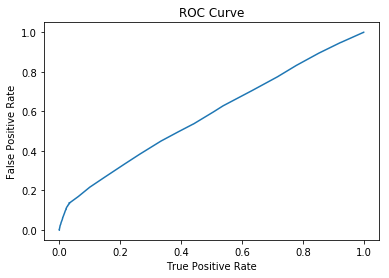

AUC: 0.5803532708885919


In [25]:
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('AUC: ' + str(trainingSummary.areaUnderROC))